<a href="https://www.kaggle.com/code/eeshawn/time-series-forecasting-with-prophet?scriptVersionId=120984150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Time Series Forecasting - Prophet

<div style="text-align:center">
<img src="https://images.unsplash.com/photo-1603713681505-6913f2e01fd4?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=800&q=80"/>
</div>
<p style="text-align:center">Photo by <a href="https://unsplash.com/pt-br/@mikeenerio?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Mike Enerio</a> on <a href="https://unsplash.com/photos/yjzZnl6HjyY?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></p>

## Introduction

Singapore has seen much progress in the energy sector, transitioning from the use of oil to natural gas over the past decades and also gradually introducing other alternative sustainable energy sources such as solar. The effects of climate change have become more pronounced and could severely impact our small island state if kept unchecked. With the target of zero net emissions by 2050, the energy sector needs to reduce emissions while ensuring supply keeps pace with the growing demand.

This creates a need for an accurate forecasting model that can accurately predict energy demand over a 365 day forecast horizon. This allows sufficient buffer for planning of new energy infrastructure projects to ensure that future energy demands can be met, ensuring stability of the overall energy network.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from prophet import Prophet
import optuna
from sklearn.metrics import mean_absolute_percentage_error, r2_score

import warnings
warnings.simplefilter("ignore")

# Retrieving Data

Data for this project is retrieved from the Energy Market Authority (EMA) Singapore statistics for [half-hourly system demand data](https://www.ema.gov.sg/statistic.aspx?sta_sid=20140826Y84sgBebjwKV).

The data has been structured in the intended format of use with Prophet, with 2 columns `ds` and `y`, representing the datetime and our target variable respectively.

In [2]:
data = pd.read_csv('/kaggle/input/half-hourly-electrical-demand-in-singapore/energy_consumption.csv', parse_dates=["ds"])

In [3]:
# check for missing values
data.isnull().sum()

ds    0
y     0
dtype: int64

In [4]:
data.head()

,ds,y
0,2012-02-06 00:00:00,4885.7671
1,2012-02-06 00:30:00,4526.6826
2,2012-02-06 01:00:00,4436.0894
3,2012-02-06 01:30:00,4361.2412
4,2012-02-06 02:00:00,4295.2305


In [5]:
data.tail()

,ds,y
193531,2023-02-19 21:30:00,6448.370941
193532,2023-02-19 22:00:00,6376.849043
193533,2023-02-19 22:30:00,6235.211282
193534,2023-02-19 23:00:00,6103.995954
193535,2023-02-19 23:30:00,5979.283868


In [6]:
# checking to ensure there are no missing dates in our data
pd.date_range(
    start=data.ds.dt.date.min(), 
    end=data.ds.dt.date.max()
    ).difference(data.ds.dt.date.unique())

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Inspecting the head and tail of the dataframe, we see that records starting from 6 Feb 2012 all the way until 19 Feb 2023, have been retrieved and there are no missing days in between.

## Data Dictionary

| Column | Type | Description |
| :-: | :-: | --- |
| ds | datetime64 | Timestamp in 30 minute intervals |
| y | float | Historical electricity system demand in MW |

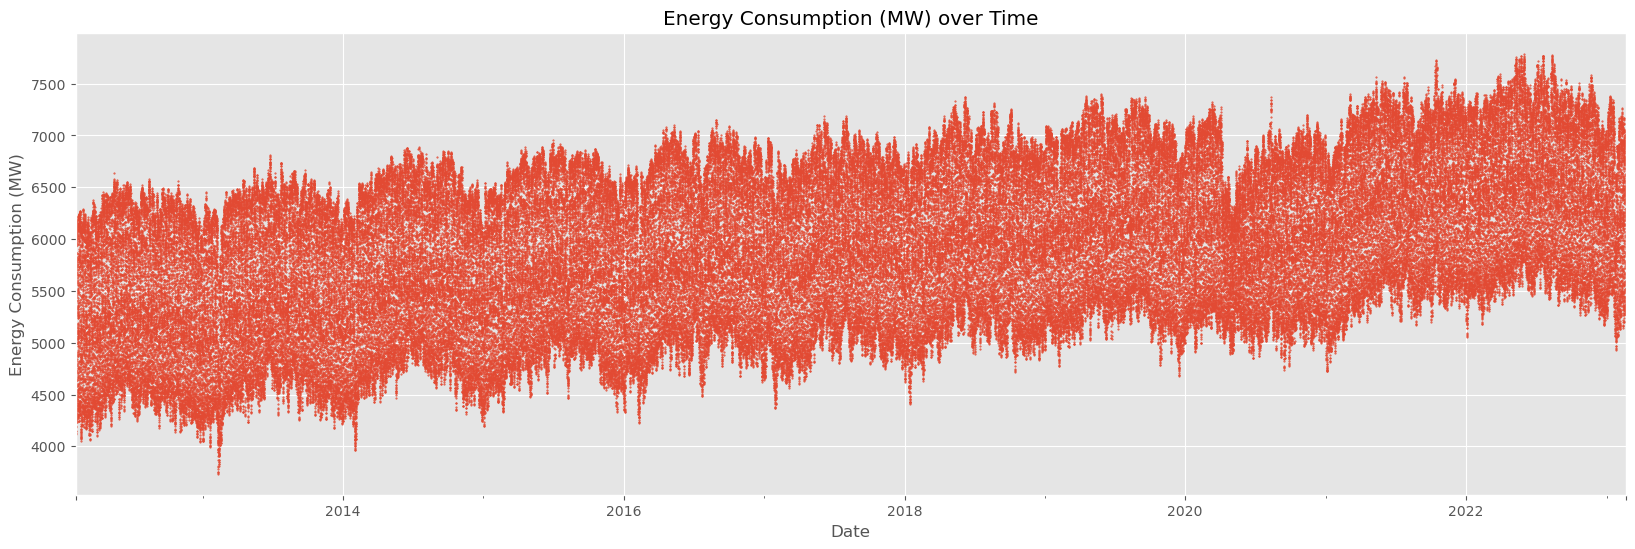

In [7]:
data.plot(
    style=".",
    x="ds",
    figsize=(20,6),
    ms=1,
    legend=[],
    title="Energy Consumption (MW) over Time",
    xlabel="Date",
    ylabel="Energy Consumption (MW)"
);

For the purposes of our forecast, we may not require excessive historical data since that could potentially slow down our model training, especially if there is no new information to be learnt. I will cut the dataset to start from 2017 instead and further split into a train and test set.

In [8]:
df = data.query("ds >= '2017-01-01' & ds < '2023-01-01'").copy().reset_index(drop=True)

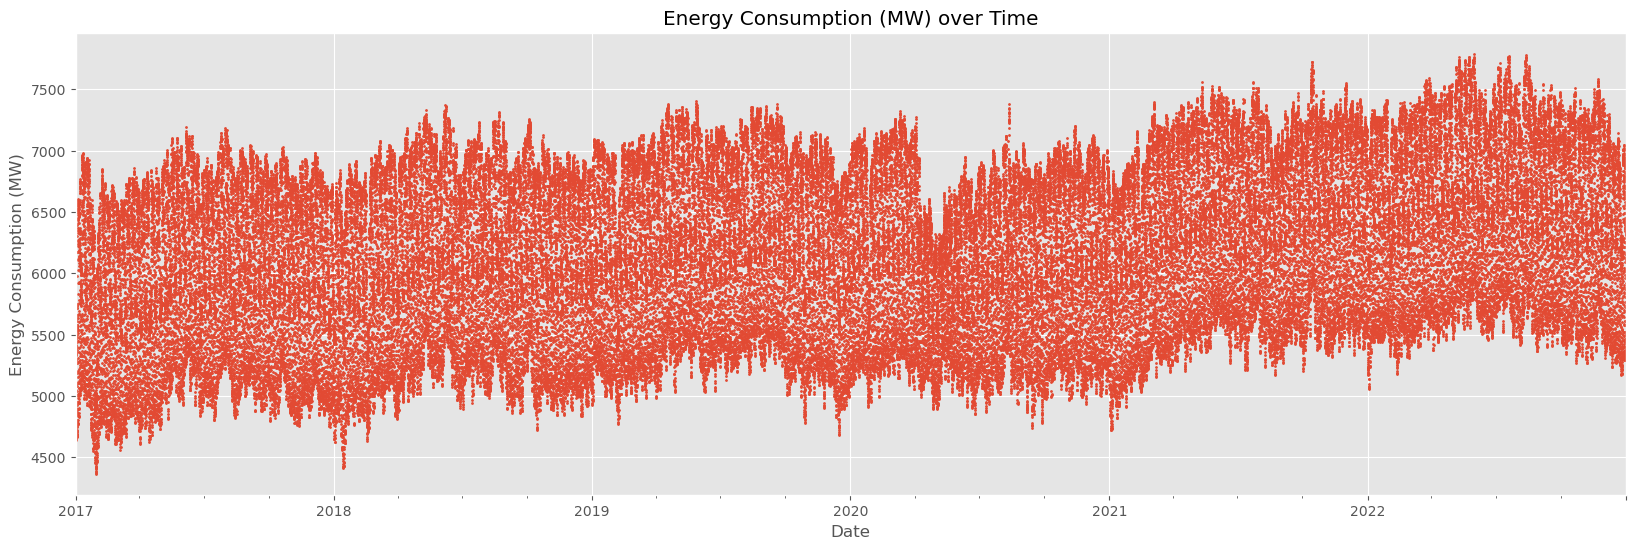

In [9]:
df.plot(
    style=".",
    x="ds",
    figsize=(20,6),
    ms=2,
    legend=[],
    title="Energy Consumption (MW) over Time",
    xlabel="Date",
    ylabel="Energy Consumption (MW)"
);

In [10]:
# split into train and test
split_date = "2022-01-01"
df_train = df.query("ds < @split_date")
df_test = df.query("ds >= @split_date")

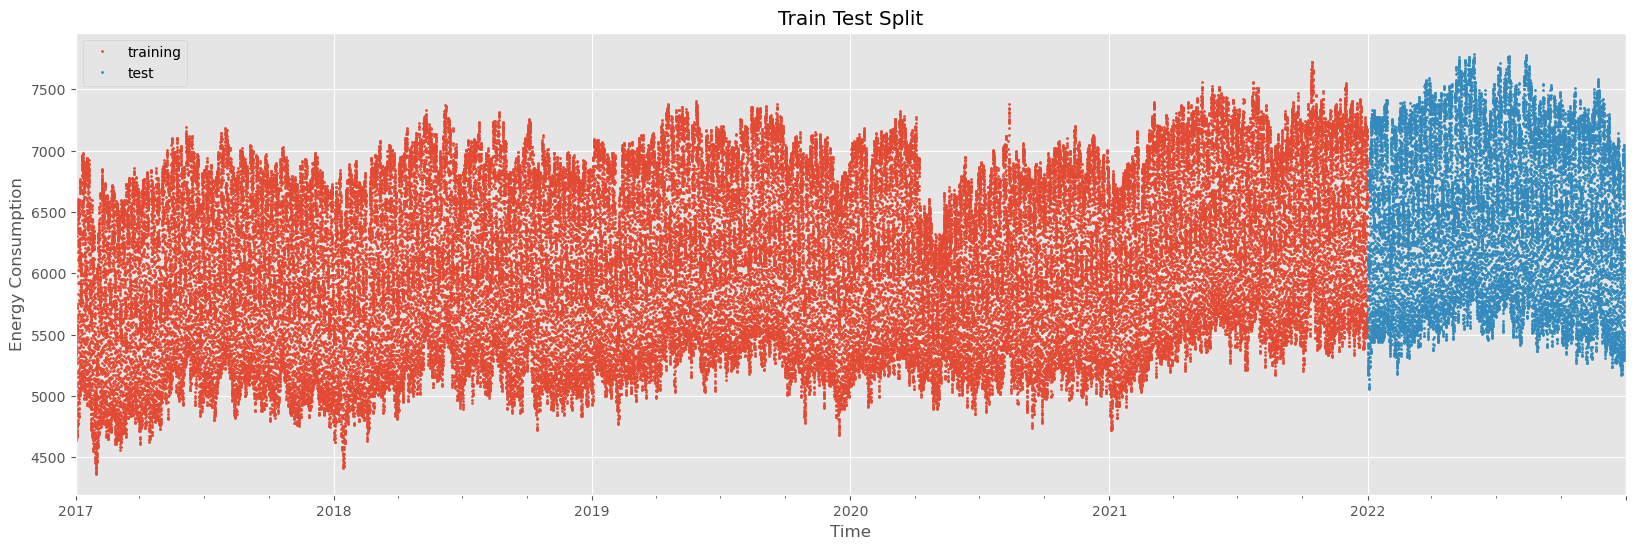

In [11]:
# visualising the split
pd.concat(
        [df_train.rename(columns={"y": "training"}), 
        df_test.rename(columns={"y": "test"})], 
        axis=0
    ).plot(
        x="ds", 
        style=".", 
        ms=2, 
        figsize=(20,6), 
        xlabel="Time", 
        ylabel="Energy Consumption", 
        title="Train Test Split"
    );

# Modelling - Prophet

`Prophet` is an open source tool released by Facebook for forecasting time series data, and is meant to be straightforward and easy to use. It is based on an additive model where trends are fit with daily, weekly and yearly seasonality, and can also account for holiday effects, which should be very applicable to this use case with electrical demand.

In this case, we can treat it as a straightforward univariate time series problem, so let's see how the model performs.

In [12]:
m = Prophet().add_country_holidays(country_name="SG").fit(df_train)

00:38:44 - cmdstanpy - INFO - Chain [1] start processing
00:41:20 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
forecast = m.predict(df)

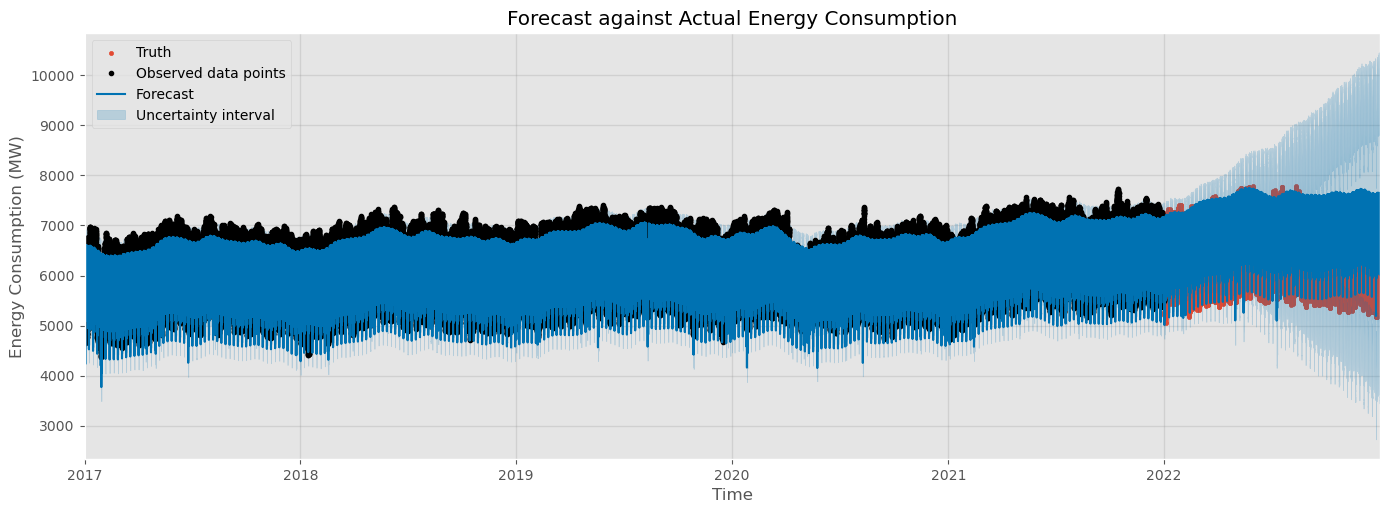

In [14]:
_, ax1 = plt.subplots(figsize=(14,5))
ax1.scatter(x=df_test.ds, y=df_test.y, label="Truth", marker=".")
m.plot(
    forecast,
    xlabel="Time",
    ylabel="Energy Consumption (MW)",
    include_legend=True,
    ax=ax1,
    )
ax1.set_xbound([df.ds.min(), df.ds.max()])
ax1.set_title("Forecast against Actual Energy Consumption")
ax1.legend(loc=2);

In [15]:
mean_absolute_percentage_error(df_test.y, forecast.query("ds in @df_test.ds").yhat) * 100

6.130501074338103

Using `Mean Absolute Percentage Error (MAPE)` to assess the model's performance, and we see the model achieves around **6.13% MAPE** in its 2022 forecasts, which is relatively good considering we have not changed any hyperparameters except for adding in holidays.

$$M = \frac{1}{n}\sum_{t=1}^n\left|\frac{A_t - F_t}{A_t}\right|$$

- $M$	=	mean absolute percentage error
- $n$	=	number of times the summation iteration happens
- $A_t$	=	actual value
- $F_t$	=	forecast value

# Hyperparameter Tuning - Optuna

As with most machine learning problems, tuning the hyperparameters could allow for greater performance than just using the base model, so let's try to find an optimal set of hyperparamters using `Optuna`.

In [16]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10, log=True),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10, log=True),
    }
    
    m = Prophet(**params).add_country_holidays(country_name='SG')
    m.fit(df_train)
    preds = m.predict(df_test)
    
    mape = mean_absolute_percentage_error(df_test['y'], preds['yhat'])
    return mape

In [17]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

In [18]:
# print(study.best_value)
# print(study.best_params)

After tuning, the model is able to achieve a performance of **3.03% MAPE**, which is a significant improvement over the base model. Using the best parameters, let's instantiate a new model and predict the electrical demand for 2023.

# Forecasting

Prophet offers a built in method to extend our existing dataframe to make future predictions for 2023, so let's see what the model is predicting.

In [19]:
# identified during Optuna study
best_params = {
    'changepoint_prior_scale': 0.181658944272581, 
    'changepoint_range': 0.8723396133910912, 
    'seasonality_prior_scale': 0.2345348256552852, 
    'holidays_prior_scale': 0.3006442168865403
}

In [20]:
m2 = Prophet(**best_params).add_country_holidays(country_name="SG").fit(df)

00:42:05 - cmdstanpy - INFO - Chain [1] start processing
00:46:26 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# extends the dates for prediction by 1 year
future = m2.make_future_dataframe(periods=48*365, freq="30T")

In [22]:
# confirm the tail of the created dates
future.tail()

,ds
122683,2023-12-31 21:30:00
122684,2023-12-31 22:00:00
122685,2023-12-31 22:30:00
122686,2023-12-31 23:00:00
122687,2023-12-31 23:30:00


In [23]:
def plot_predictions(model, model_name, future):
    """
    Predict for future using model and plot the predictions.
    
    Identifies the MAPE and maximum demand in 2023.
    """
    forecast = model.predict(future)
    mape = mean_absolute_percentage_error(df.y, forecast.query("ds in @df.ds").yhat)
    
    demand_max = forecast.query("ds >= '2023-01-01'").yhat.max()

    _, ax = plt.subplots(figsize=(14,5))
    model.plot(
        forecast,
        xlabel="Time",
        ylabel="Energy Consumption (MW)",
        include_legend=True,
        ax=ax,
        )
    ax.axhline(y=demand_max, ls="--", color="r", alpha=0.5)
    ax.annotate(f"{demand_max:.4f}", ("2023-07-01", demand_max*1.05), color="r")
    ax.set_title(f"Forecast by {model_name} Model (MAPE: {mape:.4f})")
    ax.set_xbound(["2017-01-01", "2024-01-01"])
    ax.legend(loc=2);
    
    return forecast

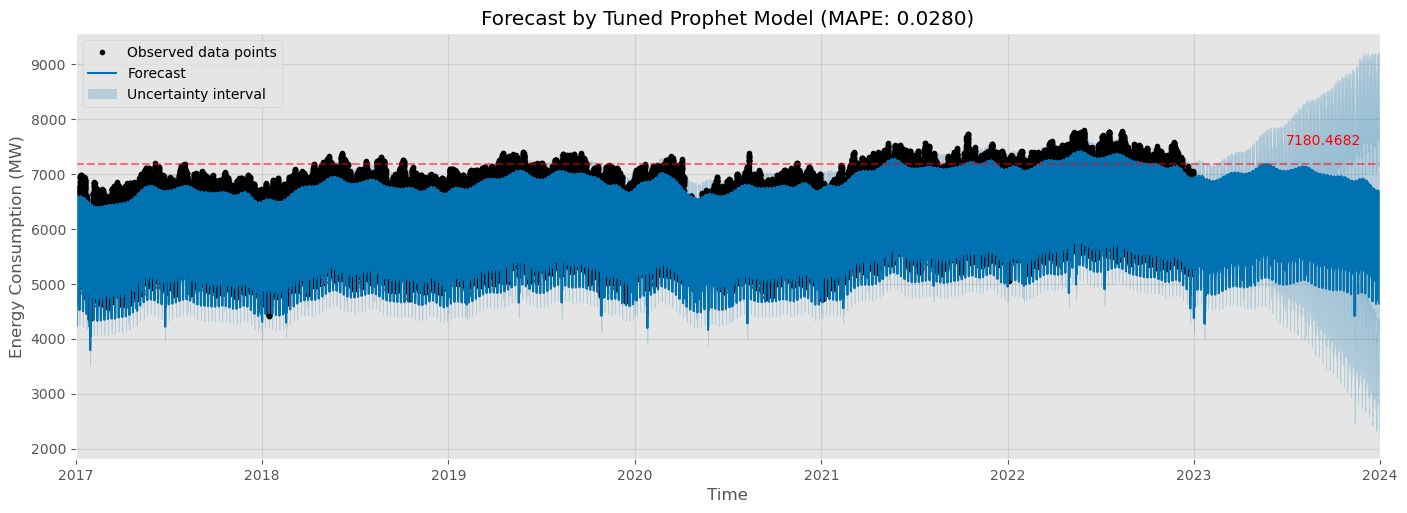

In [24]:
# forecast with tuned model
forecast2023_tuned = plot_predictions(m2, "Tuned Prophet", future)

In [25]:
# forecast with base model refit to full df
m = Prophet().add_country_holidays(country_name="SG").fit(df)



00:47:15 - cmdstanpy - INFO - Chain [1] start processing
00:50:11 - cmdstanpy - INFO - Chain [1] done processing


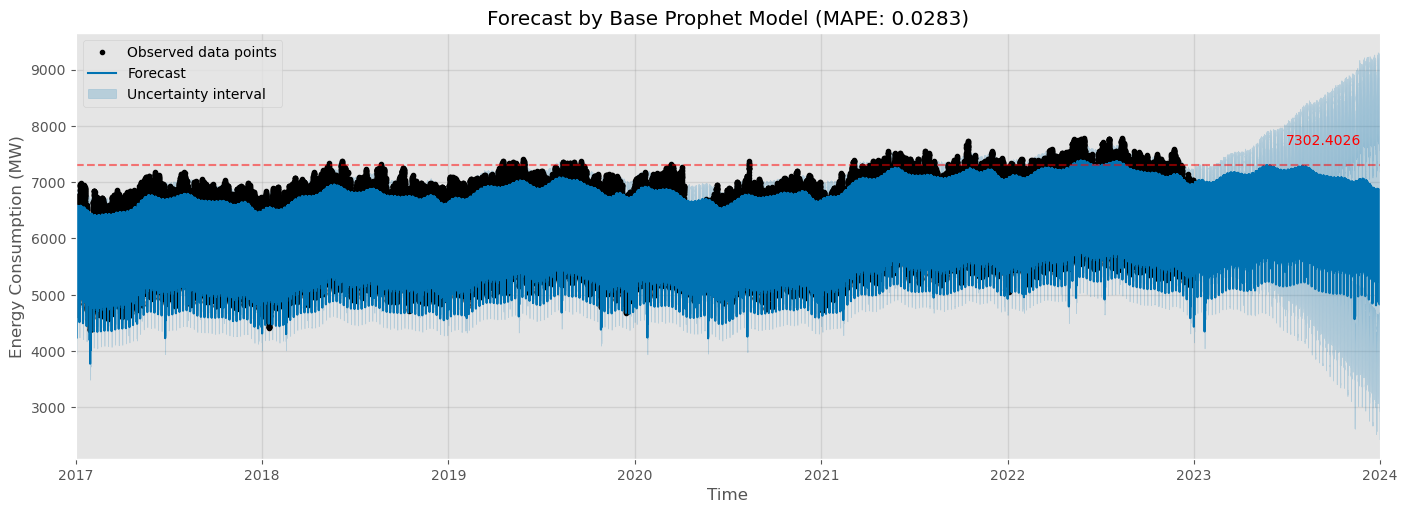

In [26]:
forecast2023 = plot_predictions(m, "Base Prophet", future)

Since we have the actual data from January 2023, let's see how well the model actually performed.

In [27]:
jan_data = data.query("ds >= '2023-01-01' & ds < '2023-02-01'")

m2_mape = mean_absolute_percentage_error(jan_data.y, forecast2023_tuned.query("ds in @jan_data.ds").yhat)
m_mape = mean_absolute_percentage_error(jan_data.y, forecast2023.query("ds in @jan_data.ds").yhat)

print("For January 2023 predictions:")
print(f"Tuned Prophet model: {m2_mape:.4f} MAPE")
print(f"Base Prophet model: {m_mape:.4f} MAPE")

For January 2023 predictions:
Tuned Prophet model: 0.0378 MAPE
Base Prophet model: 0.0367 MAPE


# Evaluation

The Prophet model is indeed easy to use, considering there were minimal steps involved and no feature engineering required to make it work with our dataset.

We see that with the hyperparameters tuned using the train and test datasets, the model achieved a 2.80% MAPE when predicting historical data, but a 3.78% MAPE when predicting for January 2023. In comparison, while a base Prophet model achieved a 2.83% MAPE on historical data, the model achieved **3.67% MAPE** when predicting for January 2023.

This suggests that there could be some level of overfitting to the training data during our hyperparameter tuning.

One of the key benefits of Prophet is the easy interpretability of the results, allowing us to visualise the time components with the `plot_components` method.

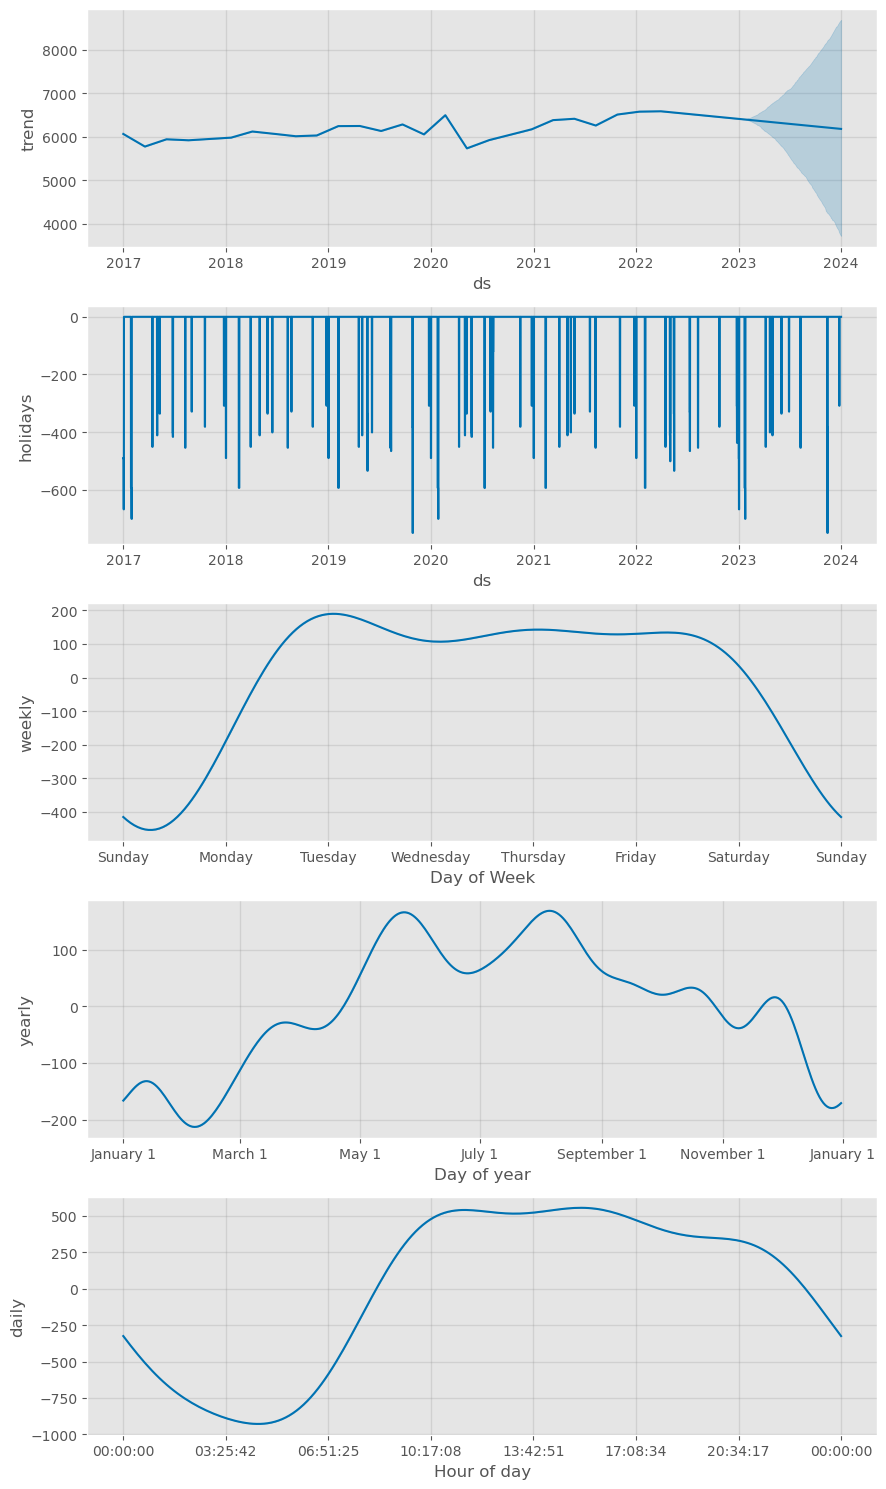

In [28]:
m2.plot_components(forecast2023_tuned);

## Future Work

While the model appears to have achieved a high fit with our historical data, it is important in time series forecasting to ensure that the model is able to perform well in production. This could involve constantly evaluating the forecasts against the actual demand as time passes, otherwise the high degree of accuracy in predicting historical data could just be our model overfitting to seen data and having low actual forecasting ability.

In a future version of this project, it would be interesting to compare Prophet's performance against other models:

- Traditional statistical models such as seasonal ARIMA
- Supervised machine learning algorithms such as XGBoost or LightGBM
- Deep learning Recurrent Neural Network (RNN)

## Recommendations

With the model forecasting that electrical demand may remain approximately the same as in 2022, this could suggest that some of the agency's efforts in reducing energy demand through encouraging energy efficiency has been effective. However, note also that there is a high level of uncertainty given our long prediction horizon. As with most time-series models, the model will need to be retrained often using the latest available data in order to maintain its performance.

# References

- The Future of Singapore's Energy Story. Energy Market Authority of Singapore. (n.d.). Retrieved March 3, 2023, from https://www.ema.gov.sg/ourenergystory 
- Merwe, R. van der. (2018, November 15). Implementing facebook prophet efficiently. Medium. Retrieved March 3, 2023, from https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3 
- Monigatti, L. (2022, August 23). Time series problems simply explained as fast food combo meals. Medium. Retrieved March 3, 2023, from https://towardsdatascience.com/time-series-problems-simply-explained-as-fast-food-combo-meals-70c6eb9bdef 
- Vasselin, H. (2022, March 17). Is Facebook prophet suited for doing good predictions in a real-world project? Medium. Retrieved March 3, 2023, from https://medium.com/artefact-engineering-and-data-science/is-facebook-prophet-suited-for-doing-good-predictions-in-a-real-world-project-44be1fe4ce91 